In [24]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
np.random.seed(24)

In [3]:
def load_data():
    
    df = pd.read_csv("./kdd2004.csv")
    df["target"] = df["target"].map({-1:0,1:1})
    
    return df

# Accuracy

Accuracy = Total number of correct predictions / total number of predictions -> Percentage of correct predictions.

For binary classification, this translate to Accuracy = TP + TN = TP+TN+FP+FN.

This is not an approriate metric for imbalance dataset due to the fact that it doesn't take into consideration the number of correctly classified examples of different classes (the minority class has very low impact on the overall accuracy).

Baseline detection = Predict always the majority class.

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
df = load_data()

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,0
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,0
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,0
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,0
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,0


In [7]:
df.shape

(145751, 75)

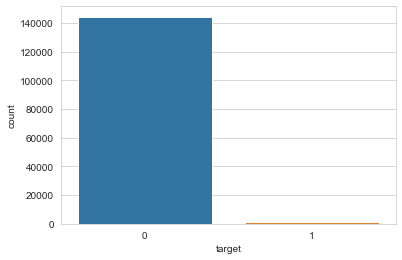

In [8]:
sns.countplot(x="target", data=df)
plt.show()

In [9]:
df["target"].value_counts(normalize=True) * 100

0    99.110812
1     0.889188
Name: target, dtype: float64

**Baseline model** : 99.11%

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [11]:
X_train.shape,X_test.shape

((97653, 74), (48098, 74))

In [12]:
y_train_base = pd.Series(np.zeros(len(y_train)))
y_test_base = pd.Series(np.zeros(len(y_test)))

## Training some ML Models

In [13]:
rf = RandomForestClassifier(n_jobs=-1, random_state=24, n_estimators=10)

rf.fit(X_train, y_train)

y_train_rf = rf.predict_proba(X_train)[:, 1]
y_test_rf = rf.predict_proba(X_test)[:, 1]

In [79]:
sgd = SGDClassifier(random_state=24, max_iter=1000, loss="log")

sgd.fit(X_train, y_train)

y_train_sgd = sgd.predict_proba(X_train)[:, 1]
y_test_sgd = sgd.predict_proba(X_test)[:, 1]

In [27]:
print(f"Accuracy baseline: {accuracy_score(y_test,y_test_base)}")
print(f"Accuracy SGDClassifier: {accuracy_score(y_test,sgd.predict(X_test))}")
print(f"Accuracy RandomForest: {accuracy_score(y_test,rf.predict(X_test))}")

Accuracy baseline: 0.9912886190694
Accuracy SGDClassifier: 0.9957586594037174
Accuracy RandomForest: 0.9972971849141337


Super high accuracy but...

In [16]:
def minority_perc(y_pred,y_true):
    return np.mean(np.where((y_pred == 1) & (y_true ==1),1,0)) * 100

In [28]:
print(f"Minority class correclty classified baseline: {minority_perc(y_test,y_test_base)}")
print(f"Minority class correclty classified SGDClassifier: {minority_perc(y_test,y_test_sgd)}")
print(f"Minority class correclty classified RandomForest: {minority_perc(y_test,y_test_rf)}")

Minority class correclty classified baseline: 0.0
Minority class correclty classified SGDClassifier: 0.6029356730009564
Minority class correclty classified RandomForest: 0.4220549711006695


... but only 42% of the observation in the minority class have been correctly classified.

# Precision, Recall and F-Measure

* True Positive Rate (Recall / sensitivity): TP(rate) = TP / TP+FN **- Minority Class**
* True Negative Rate: TN(rate): TN(rate) = TN / TN + FP **- Majority Class**
* Positive Predicted Value (Precision/specificity): PP(value) = TP / TP+FP **- Minority Class**
* Negative Predicted Value: NP(value) = TN / TN+FN **- Majority Class**

The best is to maximize both precision and recall, but sometimes it is not possible, so we have to tune the threshold we use to determine to which class belongs to the observation.

F1-Score (F-Measure) = 2 x (Precision x Recall) / (Precision + Recall)

This is the weight harmonic mean of the precision and the recall. Optimizing this metric produces the best balance between the precision and the recall.

Support refers to the actual number of occurences of a class in the dataset. It allows to highlight imbalanced datasets.

In [20]:
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            )

from yellowbrick.classifier import (ClassificationReport,
                                   DiscriminationThreshold)

## Precision

In [29]:
print(f"Precision baseline: {precision_score(y_test,y_test_base)}")
print(f"Precision SGDClassifier: {precision_score(y_test,sgd.predict(X_test))}")
print(f"Precision RandomForest: {precision_score(y_test,rf.predict(X_test))}")

Precision baseline: 0.0
Precision SGDClassifier: 0.7945205479452054
Precision RandomForest: 0.9800664451827242


/Users/alexandrecasula/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Recall

In [30]:
print(f"Recall baseline: {recall_score(y_test,y_test_base)}")
print(f"Recall SGDClassifier: {precision_score(y_test,sgd.predict(X_test))}")
print(f"Recall RandomForest: {recall_score(y_test,rf.predict(X_test))}")

Recall baseline: 0.0
Recall SGDClassifier: 0.7945205479452054
Recall RandomForest: 0.7040572792362768


## F1-Score

In [31]:
print(f"F1 Score baseline: {f1_score(y_test,y_test_base)}")
print(f"F1 Score SGDClassifier: {precision_score(y_test,sgd.predict(X_test))}")
print(f"F1 Score RandomForest: {f1_score(y_test,sgd.predict(X_test))}")

F1 Score baseline: 0.0
F1 Score SGDClassifier: 0.7945205479452054
F1 Score RandomForest: 0.7397959183673469


The LogisticRegession does a little bit better than the randomforest (with the default threshold at 0.5).

## Full classification report

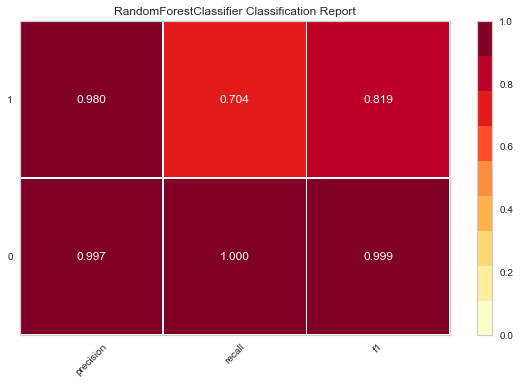

In [34]:
visualizer = ClassificationReport(rf)

visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()

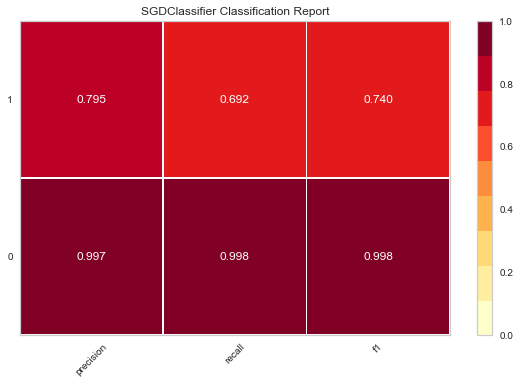

In [35]:
visualizer = ClassificationReport(sgd)

visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()

/Users/alexandrecasula/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


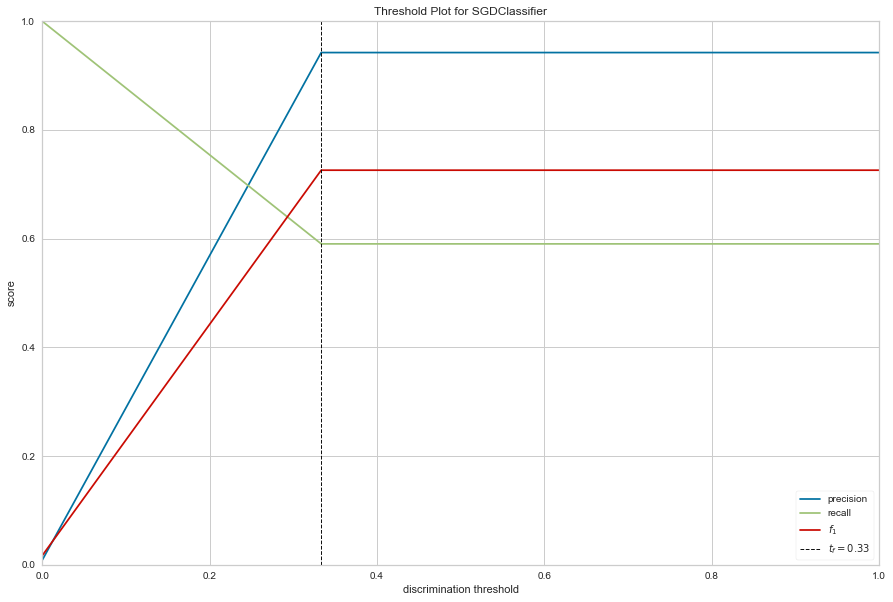

In [49]:
visualizer = DiscriminationThreshold(sgd,
                                     n_trials=1,# 1 to speed up process but can be higher to reduce the error.
                                     cv=0.1,
                                     argmax='fscore',
                                     random_state=23,
                                     is_fitted='auto',
                                     exclude="queue_rate"
                                     )

plt.figure(figsize=(15,10))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

0.33 seems to be the perfect threshold in this case for optimizing the f1 score.

# Confusion matrix, FPR and FNP

A confusion matrix is a matrix of the instances that are correctly and incorrectly classified.
False Positive Rate: FP(rate) = FP / FP + TN --> How many observations from the majority class have been classified wrongly? (Type 2 Error)
False Negative Rate: FN(rate) = FN / FN + TP --> How many observations from the minority class have been classified wrongly? (Type 1 Error)

We try to minize both of them, and they all depend on the probability threshold.

Example:
* Minimize FPR: We want to minimize the number of people that are sick but are not diagnosed sick.
* Minimize FNR: We want to minimize the number of drugs that are predicted beneficial, but are not.

In [50]:
from sklearn.metrics import confusion_matrix

## Confusion Matrix

### Baseline

In [54]:
pd.DataFrame(confusion_matrix(y_test,y_test_base))

,0,1
0,47679,0
1,419,0


### Random Forest

In [56]:
pd.DataFrame(confusion_matrix(y_test,rf.predict(X_test)))

,0,1
0,47673,6
1,124,295


### LogisticRegression

In [58]:
pd.DataFrame(confusion_matrix(y_test,sgd.predict(X_test)))

,0,1
0,47604,75
1,129,290


## FPR and FNR

In [67]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_base,labels=[0,1]).ravel()

FPR = fp / (fp + tn)
FNR = fn / (fn + tp)

print(f"FPR Baseline: {FPR}")
print(f"FNR Baseline: {FNR}")

FPR Baseline: 0.0
FNR Baseline: 1.0


FPR 0 because the model didn't identify any positive example as positive and the FNR is 1 because it classifies all the observations from the positive class incorrectly.

In [68]:
tn, fp, fn, tp = confusion_matrix(y_test,rf.predict(X_test),labels=[0,1]).ravel()

FPR = fp / (fp + tn)
FNR = fn / (fn + tp)

print(f"FPR Baseline: {FPR}")
print(f"FNR Baseline: {FNR}")

FPR Baseline: 0.00012584156546907444
FNR Baseline: 0.29594272076372313


In [69]:
tn, fp, fn, tp = confusion_matrix(y_test,sgd.predict(X_test),labels=[0,1]).ravel()

FPR = fp / (fp + tn)
FNR = fn / (fn + tp)

print(f"FPR Baseline: {FPR}")
print(f"FNR Baseline: {FNR}")

FPR Baseline: 0.0015730195683634305
FNR Baseline: 0.30787589498806683


## FPR and FNR vs Probability Threshold

In [70]:
thresholds = np.linspace(0,1,100)

In [71]:
thresholds

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [83]:
fpr_ls = []
fnr_ls = []

prob = sgd.predict_proba(X_test)[:, 1]

for threshold in thresholds:

    # Class from the threshold
    preds = np.where(prob >= threshold, 1, 0)

    tn, fp, fn, tp = confusion_matrix(y_test, preds, labels=[0, 1]).ravel()

    FPR = fp / (fp + tn)
    FNR = fn / (fn + tp)

    fpr_ls.append(FPR)
    fnr_ls.append(FNR)

metrics = pd.concat([pd.Series(fpr_ls), pd.Series(fnr_ls)], axis=1)

In [84]:
metrics.columns = ["fpr","fnr"]
metrics.index = thresholds

In [85]:
metrics.head()

,fpr,fnr
0.000000,1.000000,0.000000
0.010101,0.001615,0.307876
0.020202,0.001594,0.307876
0.030303,0.001594,0.307876
0.040404,0.001594,0.307876


<Figure size 864x720 with 0 Axes>

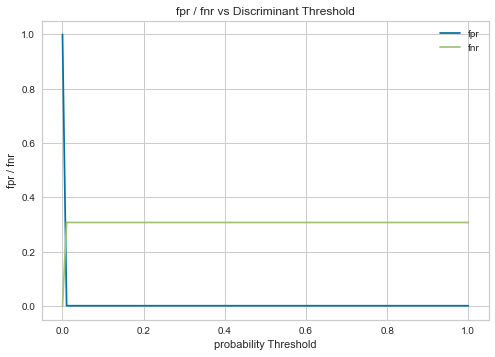

In [93]:
plt.figure(figsize=(12,10))
metrics.plot()
plt.xlabel("probability Threshold")
plt.ylabel("fpr / fnr")
plt.title("fpr / fnr vs Discriminant Threshold")
plt.show()

# Geometric Means, Dominance, Index of Imbalance Accuracy

# ROC-AUC

# Precision-Recall Curve